In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from scipy import integrate, optimize
from sklearn.cluster import DBSCAN
from bisect import bisect_left

In [ ]:
n = 25                  # Number of agents
p = 2                   # Exponent for transport cost
lambda_param = 20       # Default transport cost weight
sigma = 0.2             # Default kernel width
n_iter = 400            # Maximum number of iterations for optimization
np.random.seed(5)

bounds = [(0, 1) for i in range(n)]       # Boundary of agents

def uniform_rho(x):
    return 1 if 0 < x < 1 else 0

rho = uniform_rho  # Use uniform resource distribution

In [ ]:
def neg_inv_quad(r, sigma):
    return -(1/(1+(r**2)/(sigma**2)))

def pop_k(x, sigma):
    total = 0.0
    n = len(x)
    for i in range(n):
        for j in range(n):
            d = np.abs(x[i] - x[j])
            total += neg_inv_quad(d, sigma)
    return total


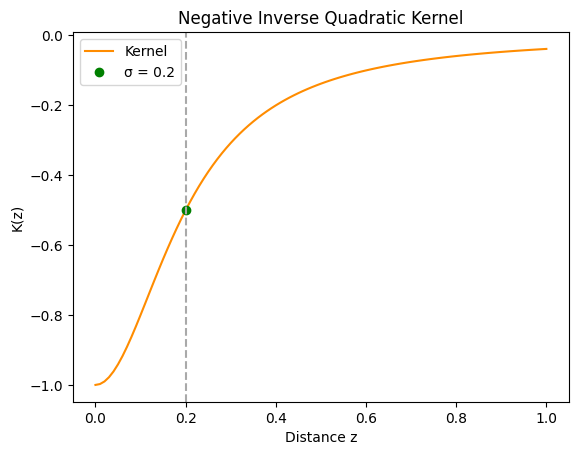

In [ ]:
kx_space = np.linspace(0, 1, 101)
pk_space = [neg_inv_quad(x, sigma) for x in kx_space]

plt.figure()
plt.plot(kx_space, pk_space, color='darkorange')
plt.plot(sigma, neg_inv_quad(sigma, sigma), 'go')
plt.axvline(x=sigma, color='darkgray', linestyle='--', linewidth=1.5, label=r'$\sigma$')
plt.xlabel("Distance z")
plt.ylabel("K(z)")
plt.legend(["Kernel", f"σ = {sigma}"])
plt.title("Negative Inverse Quadratic Kernel")
plt.show()

In [ ]:
def territories():
    return [k / n for k in range(n + 1)]

T = territories()

In [ ]:
def energy(x, borders, lambda_param, sigma):
    pop_energy = pop_k(x, sigma)
    transport_energy = 0.0
    for i in range(n):
        integrand = lambda y: np.abs(x[i] - y)**p * rho(y)
        cost, _ = integrate.quad(integrand, borders[i], borders[i + 1])
        transport_energy += cost
    return (1 / (2 * n**2)) * pop_energy + (lambda_param / 2) * transport_energy

In [ ]:
def dbscan_cities(agents, a_sigma, min_pop=2):
    X = np.array(agents).reshape(-1, 1)
    db = DBSCAN(eps=a_sigma, min_samples=min_pop, metric='euclidean')
    labels = db.fit_predict(X)
    cities, pops = [], []
    for cluster_id in set(labels):
        if cluster_id == -1:
            continue
        members = X[labels == cluster_id].ravel()
        pops.append(len(members))
        cities.append(members.mean())
    return np.array(cities), np.array(pops)


In [ ]:
def vary_parameters(sigma_values, lambda_values):
    result_grid = np.zeros((len(sigma_values), len(lambda_values)))
    for i, sig in enumerate(sigma_values):
        for j, lam in enumerate(lambda_values):
            trial_results = []
            for run in range(6):
                seed = hash((sig, lam, run)) % (2**32)
                np.random.seed(seed)
                if (run == 0):
                  x0 = 0.5*np.ones(25)
                  x0 += np.random.randn(n) * 0.04
                  x0 = np.sort(x0)
                  x0 = np.clip(x0, 0, 1)
                elif (run == 1):
                  x0 = np.array([0.4, 0.4, 0.4, 0.4,
                                 0.4, 0.4, 0.4, 0.4,
                                 0.4, 0.4, 0.4, 0.4,
                                 0.5,
                                 0.6, 0.6, 0.6, 0.6,
                                 0.6, 0.6, 0.6, 0.6,
                                 0.6, 0.6, 0.6, 0.6])
                  x0 += np.random.randn(n) * 0.02
                  x0 = np.sort(x0)
                  x0 = np.clip(x0, 0, 1)
                elif (run == 2):
                  x0 = np.array([0.3, 0.3, 0.3, 0.3, 0.3,
                                0.4, 0.4, 0.4, 0.4, 0.4,
                                0.5, 0.5, 0.5, 0.5, 0.5,
                                0.6, 0.6, 0.6, 0.6, 0.6,
                                0.7, 0.7, 0.7, 0.7, 0.7])
                  x0 += np.random.randn(n) * 0.01
                  x0 = np.sort(x0)
                  x0 = np.clip(x0, 0, 1)
                else:
                  x0 = np.linspace(0, 1, n) + np.random.randn(n) * 0.002 * run
                  x0 = np.sort(x0)
                  x0 = np.clip(x0, 0, 1)
                res = optimize.minimize(lambda x: energy(x, T, lam, sig), x0=x0,
                                        method='L-BFGS-B', bounds = bounds,
                                        options={'maxiter': n_iter})
                energy_value = res.fun
                num_cities = len(dbscan_cities(res.x, 0.5/25)[0])
                trial_results.append((energy_value, num_cities, res.x))
            best_trial = min(trial_results, key=lambda t: t[0])
            best_energy = best_trial[0]
            best_cities = best_trial[1]
            best_x = best_trial[2]
            result_grid[i, j] = best_cities
    return result_grid

In [ ]:
# Define ranges for σ and λ.
sigma_range = np.linspace(0.01, 0.10, 37)
lambda_range = np.logspace(-1, 8, 19, base=2)
results_grid = vary_parameters(sigma_range, lambda_range)

KeyboardInterrupt: 

In [ ]:
Lambda, Sigma   = np.meshgrid(lambda_range, sigma_range)
sigma_vals      = Sigma.flatten()
lambda_vals     = Lambda.flatten()
results         = results_grid.flatten()

# mask for the zeros
zero_mask = (results == 0)

# bins for the plot
min_count = int(np.min(results[~zero_mask]))
max_count = int(np.max(results[~zero_mask]))
# create integer bins [0.5,1.5), [1.5,2.5), ..., [M-0.5, M+0.5)
bins = np.arange(min_count - 0.5, max_count + 1.5, 1.0)

# viridis colormap
cmap = plt.cm.viridis
# create a norm which maps each bin to a discrete color
norm = BoundaryNorm(bins, ncolors=cmap.N, clip=True)

plt.figure(figsize=(8, 4))

# non-zero points with discrete viridis
sc = plt.scatter(sigma_vals[~zero_mask], lambda_vals[~zero_mask],
    c=results[~zero_mask],
    cmap=cmap,
    norm=norm,
    s=50,
    alpha=0.7
)

# zeros in red
plt.scatter(
    sigma_vals[zero_mask],
    lambda_vals[zero_mask],
    color='red',
    s=50,
    alpha=0.7,
    label='Zero cities'
)

# discretized colorbar
cb = plt.colorbar(sc, boundaries=bins, ticks=np.arange(min_count, max_count+1))
cb.set_label("Number of Cities")

# overlay λ = 2/σ line
sigma_line  = np.linspace(sigma_range.min(), sigma_range.max(), 500)
lambda_line = 2.0 / sigma_line
plt.plot(
    sigma_line,
    lambda_line,
    linestyle=':',
    color='black',
    linewidth=2,
    label=r'$\lambda = \frac{2}{\sigma}$'
)

plt.xlabel("σ")
plt.ylabel("λ")
plt.yscale('log')
plt.title("Scatter Plot: λ vs σ Colored by Number of Cities")
plt.legend(loc='lower right')
plt.show()